In [29]:
import SimPEG as simpeg
from SimPEG import NSEM, Mesh
#import MT_poster_utils 
from IPython.display import HTML
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import copy
import telluricpy

In [2]:
# Define the area of interest
bw, be = -250., 250
bs, bn = -250., 250.
bb, bt = -500.,0.

In [17]:
[botPadI[-i] for i in range(1,len(botPadI)+1)]

[93.311999999999983,
 139.96799999999996,
 209.95199999999994,
 314.92799999999994,
 472.39199999999988,
 708.58799999999985,
 1062.8819999999998]

In [15]:
botPadI

array([ 1062.882,   708.588,   472.392,   314.928,   209.952,   139.968,
          93.312])

In [44]:
mesh.vectorCCz

array([-1628.76508594, -1041.36795703,  -649.76987109,  -388.70448047,
        -214.66088672,   -98.63182422,    -5.80857422,    76.30430078,
         147.70680078,   210.87055078,   265.79555078,   314.38305078,
         356.63305078,   398.88305078,   441.13305078,   478.50805078,
         511.00805078,   543.50805078,   576.00805078,   608.50805078,
         637.25805078,   662.25805078,   687.25805078,   712.25805078,
         737.25805078,   762.25805078,   793.50805078,   840.38305078,
         910.69555078,  1016.16430078,  1174.36742578,  1411.67211328,
        1767.62914453])

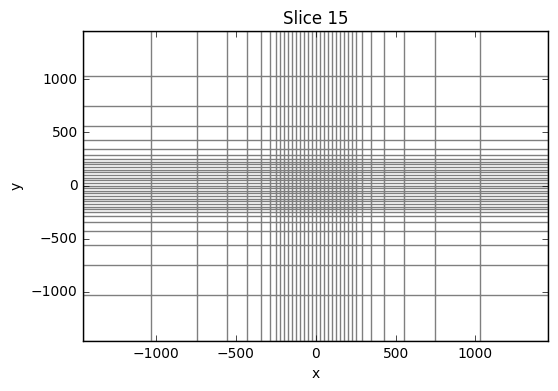

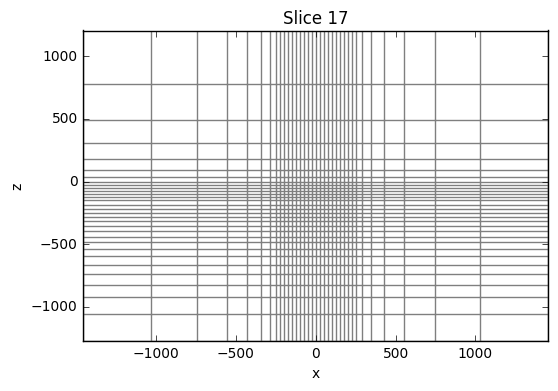

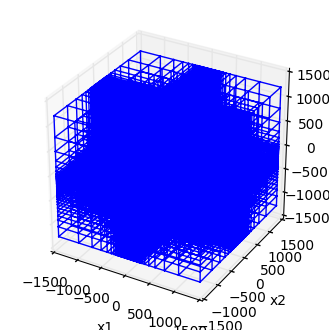

34680
107236


In [52]:
#Cell size
csx, csy, csz = 25.,25.,25.
# Number of core cells in each directiPon s
ncx, ncy, ncz = 20,20,20
# Number of padding cells to add in each direction
npad = 7
# Vectors of cell lengthts in each direction
hx = [(csx,npad, -1.5),(csx,ncx),(csx,npad, 1.5)]
hy = [(csy,npad, -1.5),(csy,ncy),(csy,npad, 1.5)]
hz= [(csz,npad,-1.5),(csz,ncz),(csy,npad, 1.5)]
#hz = [(csz,npad, -1.5),(csz,ncz),(csz,npad,1.5)]

nrCcore = [6, 5, 4, 2, 2, 2, 2]
airPad = simpeg.Utils.meshTensor([(csz,7,1.5)])
vCore = np.concatenate([ np.ones(i)*s for i, s in zip(nrCcore,(simpeg.Utils.meshTensor([(csz,1),(csz,5,1.3)])))])[::-1]
botPad = simpeg.Utils.meshTensor([(vCore[0],2,-1.5)])
hz = np.concatenate((botPad,vCore,airPad))

# Create mesh
mesh = Mesh.TensorMesh([hx, hy, hz],x0="CCN")
# Map mesh coordinates from local to UTM coordiantes
mesh.x0[2] = mesh.x0[2]+np.sum(airPad)
#mesh.x0[2] = mesh.x0[2]- csz/2.#-np.max(mesh.vectorCCz[npad:-npad]) 

mesh.plotSlice(np.ones(mesh.nC)*np.nan, grid=True)
mesh.plotSlice(np.ones(mesh.nC)*np.nan, grid=True, normal="Y")
mesh.plotGrid()
plt.gca().set_aspect('equal')
plt.show()

print mesh.nC
print mesh.nF

In [53]:
mesh.vectorNz

array([ -1.26788869e+03,  -1.05903638e+03,  -9.19801500e+02,
        -8.26978250e+02,  -7.34155000e+02,  -6.62752500e+02,
        -5.91350000e+02,  -5.36425000e+02,  -4.81500000e+02,
        -4.39250000e+02,  -3.97000000e+02,  -3.54750000e+02,
        -3.12500000e+02,  -2.80000000e+02,  -2.47500000e+02,
        -2.15000000e+02,  -1.82500000e+02,  -1.50000000e+02,
        -1.25000000e+02,  -1.00000000e+02,  -7.50000000e+01,
        -5.00000000e+01,  -2.50000000e+01,  -2.27373675e-13,
         3.75000000e+01,   9.37500000e+01,   1.78125000e+02,
         3.04687500e+02,   4.94531250e+02,   7.79296875e+02,
         1.20644531e+03])

In [65]:
sig_air = 1e-8
sphere_depth = 200.
sig_back = 1e-3
sig_sphere = 1e-1
sphere_r = 100.
sigma = sig_back*np.ones(mesh.nC)

#air cells
air = mesh.gridCC[:,2]>0.
sigma[air]=sig_air

#Define the sphere limit
inds = (np.sqrt((mesh.gridCC[:,2]+sphere_depth)**2.+(mesh.gridCC[:,1])**2.+(mesh.gridCC[:,0])**2.))< sphere_r
sigma[inds] = sig_sphere;

In [66]:
np.where(inds)

(array([14432, 14433, 14466, 14467, 15519, 15520, 15521, 15522, 15552,
        15553, 15554, 15555, 15556, 15557, 15586, 15587, 15588, 15589,
        15590, 15591, 15620, 15621, 15622, 15623, 15624, 15625, 15654,
        15655, 15656, 15657, 15658, 15659, 15689, 15690, 15691, 15692,
        16642, 16643, 16674, 16675, 16676, 16677, 16678, 16679, 16708,
        16709, 16710, 16711, 16712, 16713, 16741, 16742, 16743, 16744,
        16745, 16746, 16747, 16748, 16775, 16776, 16777, 16778, 16779,
        16780, 16781, 16782, 16810, 16811, 16812, 16813, 16814, 16815,
        16844, 16845, 16846, 16847, 16848, 16849, 16880, 16881, 17797,
        17798, 17799, 17800, 17830, 17831, 17832, 17833, 17834, 17835,
        17863, 17864, 17865, 17866, 17867, 17868, 17869, 17870, 17897,
        17898, 17899, 17900, 17901, 17902, 17903, 17904, 17931, 17932,
        17933, 17934, 17935, 17936, 17937, 17938, 17965, 17966, 17967,
        17968, 17969, 17970, 17971, 17972, 18000, 18001, 18002, 18003,
      

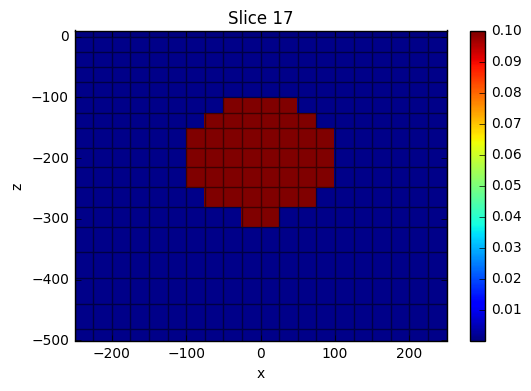

In [67]:
a = mesh.plotSlice(sigma, grid=True, normal="Y")
plt.gca().set_xlim([-250.,250])
plt.gca().set_ylim([-500.,10.])
plt.colorbar(a[0])

In [68]:
freq = np.logspace(5,3,16)
print freq

[ 100000.           73564.22544596   54116.95265465   39810.71705535
   29286.44564625   21544.34690032   15848.93192461   11659.1440118
    8576.95898591    6309.5734448     4641.58883361    3414.54887383
    2511.88643151    1847.84979742    1359.35639088    1000.        ]


In [69]:
print 500./np.sqrt(freq*sig_back)

[  50.           58.29572006   67.96781954   79.24465962   92.39248987
  107.7217345   125.59432158  146.43222823  170.72744369  199.05358528
  232.07944168  270.58476327  315.47867224  367.82112723  428.8479493   500.        ]


In [73]:
# Make the rxLocations file
x,y,z = np.meshgrid([-250.,0],[0.],[0.])
locs = np.hstack((x.reshape(-1,1),y.reshape(-1,1),z.reshape(-1,1)))


In [74]:
rxList = []
for rxType in ['zxxr','zxxi','zxyr','zxyi','zyxr','zyxi','zyyr','zyyi','tzxr','tzxi','tzyr','tzyi']:
    rxList.append(NSEM.Rx(locs,rxType))
# Source list
srcList =[]
for freq in freqList:
    srcList.append(NSEM.SrcNSEM.polxy_1Dprimary(rxList,freq))
# Survey MT
survey = NSEM.Survey(srcList)
# Background 1D model
sigma1d = mesh.r(bgsigma,'CC','CC','M')[0,0,:]
## Setup the problem object
problem = NSEM.Problem3D_ePrimSec(mesh,sigmaPrimary = sigma1d)
problem.verbose = True

problem.Solver = MumpsSolver
problem.pair(survey)

## Calculate the fields
stTime = time.time()
print 'Starting calculating field solution at ' + time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
sys.stdout.flush()
FmtSer = problem.fields(sigma)
print 'Ended calculation field at ' + time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
print 'Ran for {:f}'.format(time.time()-stTime)

## Project data
stTime = time.time()
print 'Starting projecting fields to data at ' + time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
sys.stdout.flush()
mtData = NSEM.Data(survey,survey.eval(FmtSer))
print 'Ended projection of fields at ' + time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
print 'Ran for {:f}'.format(time.time()-stTime)
mtStArr = mtData.toRecArray('Complex')
SimPEG.np.save('MTdataStArr_nsmesh_HKPK1Fin_noExtension',mtStArr)
try:
    pickle.dump(open('MTfields_HKPK1Fin.pkl','wb'),FmtSer)
except:
    fieldsDict = {}
    for freq in survey.freqs:
        src = survey.getSrcByFreq(freq)
        fieldsDict[freq] = {'e_pxSolution':FmtSer[src,'e_pxSolution'],'e_pySolution':FmtSer[src,'e_pySolution']}
    with open('MTfields_HKPK1Fin.pkl','wb') as out:
        pickle.dump(fieldsDict,out,2)

del FmtSer, mtStArr, mtData
gc.collect()

# Read in the fields dicts
if False:
    FmtSer = problem.fieldsPair()
    for freq, fD in fieldsDict.iteritems():
        src = survey.getSrcByFreq(freq)
        FmtSer[src,'e_pxSolution'] = fD['e_pxSolution']
        FmtSer[src,'e_pySolution'] = fD['e_pySolution']


TypeError: 'module' object is not callable

In [81]:
NSEM.Rx(locs,rxType)

TypeError: 'module' object is not callable

In [78]:
NSEM.Rx??